# Basic operations on pointclouds

This notebook discusses the basics of pointcloud processing. It begins with the elementary structure of a pointcloud and details its most common additional attributes. A second part is dedicated to the usual transformations that may be applied to poinclouds. The third an last part deals with the concept of subsampling.

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt

## What is a pointcloud?

In general terms, a pointcloud refers to a set of data points in space (this space may have multiple and inhomogeneous dimensions such as time, temperature, distance, etc.). We assume here a three-dimensional space where **a pointcloud is a representation of a shape or an object** (or pieces of one or several objects).

Pointclouds may be obtained from real objects (through "3D scanning" processes), from digital objects (through "3D modeling" processes), or even created from scratch. This results in the multiplication of available data, but also formats, each one being tailored for specific uses and software.

For the sake of simplicity, this notebook uses an ASCII-based format (i.e., a plain text file that uses whitespaces to separate values and newlines to separate records). Note that more complex binary formats (such as PLY, LAS, or E57) must be privileged for large pointclouds.

A pointcloud is then simply loaded using Numpy:

In [2]:
points = np.loadtxt("./data/stanford_bunny_simple.xyz")
print("Here is the content of our pointcloud:\n", points)
print("Its shape is:", points.shape)

Here is the content of our pointcloud:
 [[-25.5861 106.9803  42.684 ]
 [-30.1628  93.312  -47.9823]
 [ -8.5167 100.3486  73.1544]
 ...
 [ 39.3746 100.979   -1.1485]
 [-54.9932  84.2855 -32.3682]
 [-77.221  104.7658 -26.0204]]
Its shape is: (4096, 3)


We can see that **a pointcloud** (usually noted $p$) **is basically a "list" of points** (the notion of set is more appropriate in theory) defined by their cartesian coordinates (i.e., their position from the origin according to the x, y, and z axes).

Here data are stored in a Numpy array, which is better than a mere list for numerical operations. Points are usually listed *row-wise* (one point per line), resulting in a vector of shape $(n, 3)$ ($n$ being the total number of points), although the contrary (i.e., *column-wise*) is also found.

Points may be visualized using Matplotlib if their number is not too large (otherwise other libraries or dedicated software may be needed). Note the **sparse** (some areas of the object may not be sampled), **irregular** (some areas may have different densities), and **unordered** (the "order" of points is not important) nature of pointclouds.

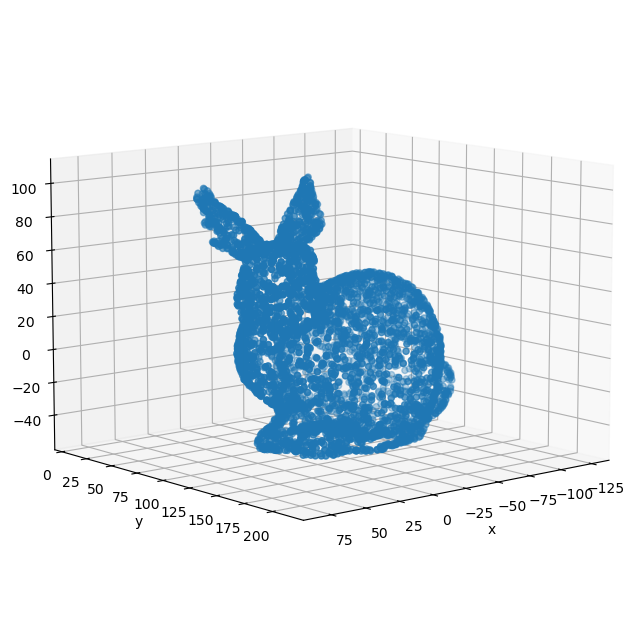

In [3]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 50)
plt.axis("equal")
plt.show()



## Common attributes

As seen before, each point of the pointcloud has *a minima* three coordinates (x, y, and z). However, it is not uncommon to find other information. Among **the most popular ones are normals, colors, and scalar fields**.

In practice, additional coordinates are added to the points' position, making the pointcloud a vector of shape $(m, n)$, with $m \geq 3$. It is however recommended to "group" each kind of information in a separate vector (e.g., one for position, one for normals, one for colors, etc.).


In [4]:
data = np.loadtxt("./data/stanford_bunny_custom.xyz")
print("Here is the shape of our data:", data.shape)
points = data[:, :3]
normals = data[:, 3:6]
colors = data[:, 6:9]
scalar = data[:, -1]

Here is the shape of our data: (4096, 10)


### Normals

**A normal is a vector that is assumed to be perpendicular to the sampled surface** at a given point. 

A normal vector $n_i$ associated to a point $p_i$ has three components, noted $n_{ix}$, $n_{iy}$, and $n_{iz}$. It is generally a unit vector, which means that its norm is equal to one, $||n_i|| = 1$.

Normals are sometimes given directly by the acquisition device or may be easily calculated when the sampled surface is known (if a pointcloud comes from a CAD model for example). When this is not the case, normals can be estimated by various methods (we'll get to it in a next notebook).

In practice, similar to points, normals are usually given in a vector of shape $(n, 3)$ ($n$ being the total number of points).

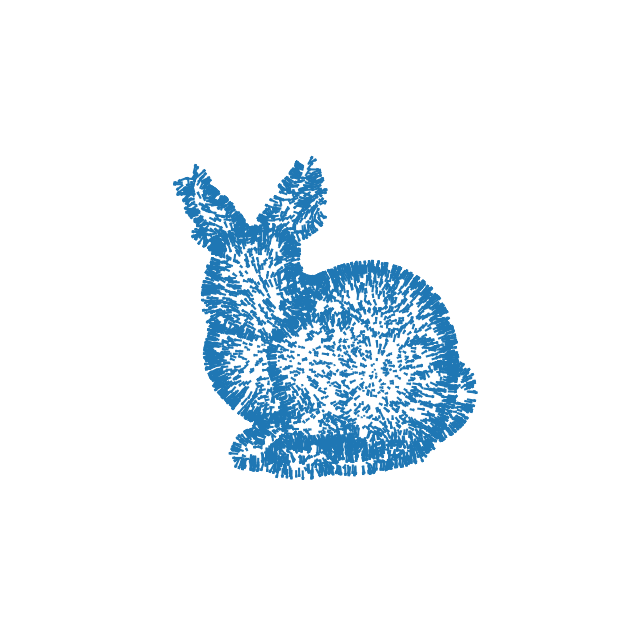

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.quiver(points[:, 0], points[:, 1], points[:, 2],
          5.*normals[:, 0], 5.*normals[:, 1], 5.*normals[:, 2]) # we make normals a little bit larger for visualization purposes
ax.view_init(10, 60)
ax.set_axis_off()
plt.axis("equal")
plt.show()

Normals provide useful local information about the geometrical properties of the sampled surface or object. In particular, normals help define the notion of "interior/exterior" (normals are supposed to be pointing "outside" by convention).

Normals are used as inputs in many pointcloud processing algorithms, but also for visualization/rendering purposes. Computing the angle between an incident ray and the normals is a first approach to simulating the reflection of light on a given object, as shown below.

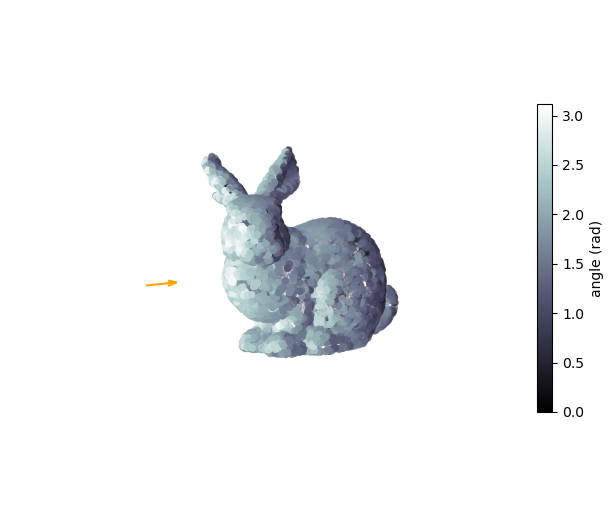

In [20]:
# Incident ray (unit vector giving the direction of light)
v_dir = np.array([-1., 0., 0.])

# Angle between the normals and the incident ray
theta = np.arccos(normals @ v_dir)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          c=theta, cmap="bone")
v_mag =  np.linalg.norm(v_dir * points.ptp())/10 # used for visualization purposes: magnitude
v_loc = points.mean(axis=0) - 5 * v_mag * v_dir # used for visualization purposes: position
ax.quiver(v_loc[0], v_loc[1], v_loc[2], v_mag*v_dir[0], v_mag*v_dir[1], v_mag*v_dir[2],
          color='orange')

ax.view_init(10, 60)
ax.set_axis_off()
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('angle (rad)')
plt.axis("equal")
plt.show()

### Colors

Colors are more easily defined and account for the visual appearance of each point.

There are several ways to define colors, one of the most common is **the RGB color model that defines a color as an addition of the red, green and blue** primary colors.

A RGB color vector associated to a point $p_i$ has three components, noted R, G, and B, with values generally ranging from 0 to 255 (integers) or from 0 to 1 (floats).

Colors are sometimes given by the acquisition device or may be easily deduced if the pointcloud comes from a colored virtual object. However, in the first case, color values may vary to the acquisition conditions (the lighting in particular).

In practice, similar to points and normals, colors are usually given in a vector of shape $(n, 3)$ ($n$ being the total number of points).

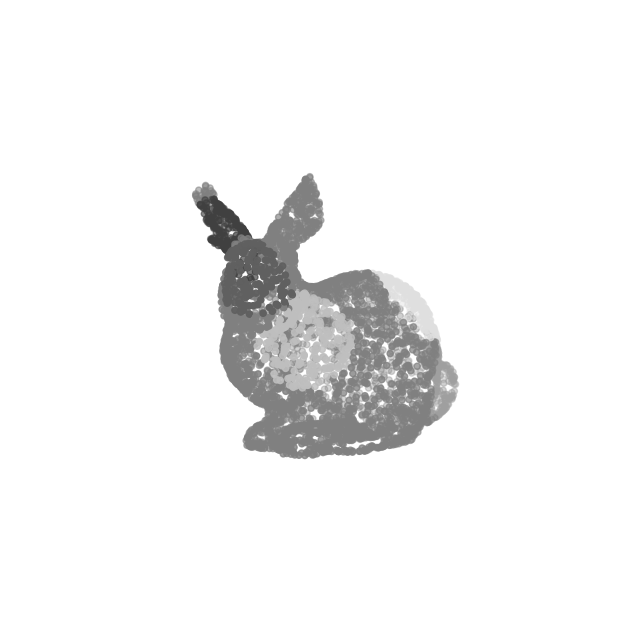

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c=colors) # RGB values need to be normalized in Matplotlib
ax.view_init(10, 60)
ax.set_axis_off()
plt.axis("equal")
plt.show()

### Scalar fields

In general terms, a scalar field is a function associating a single number to every point in a space. Here it simply designates **a number associated with a point**.

This number may have any value and dimension.

Scalar fields are sometimes given by the acquisition device or may result of a calculation. In practice, a scalar field is used to associate any quantity of interest with the pointcloud.

In practice, a scalar fied is usually given in a vector of shape $(n, 1)$ ($n$ being the total number of points). There may be several scalar fields associated with a given pointcloud.

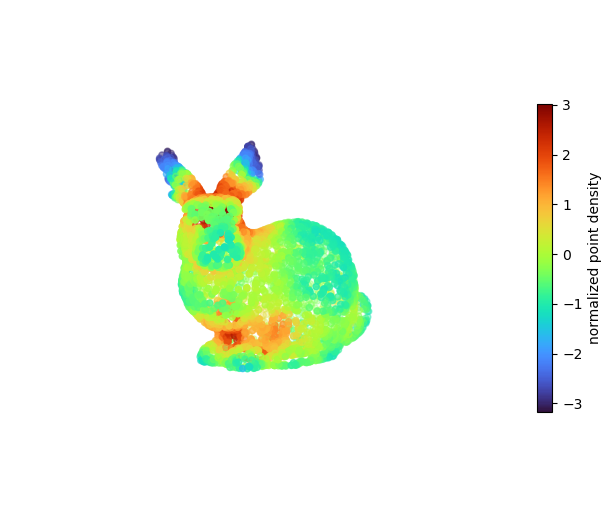

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c=scalar, cmap="turbo")
ax.view_init(10, 60)
ax.set_axis_off()
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('normalized point density')
plt.axis("equal")
plt.show()

## Transformations

Many kinds of geometric transformations may be applied to pointclouds (their study from a mathematical perspective is of course beyond the scope of this discussion). In the context of pointcloud processing, the following transformations are mainly considered (alone or combined):
- Translations
- Rotations
- Reflections
- Scaling
- Shearing

These transformations may roughly be classified according to the properties of the initial pointcloud that are preserved. For example, rigid motions (or Euclidean transformations or isometries) - that include translations, rotations and reflections - preserve angles and distances between points. On the other hand, affine transformations - that include rigid motions plus scaling and shearing - do not.

### Translations

A translation moves every point of the pointcloud in the same direction.

In practice, a constant vector $t$ is simply added to each point of the pointcloud: 
\begin{equation*}
p' = p + t
\end{equation*}
Thanks to broadcasting this operation may be vectorized in Numpy, resulting in more readable code and faster execution.

A translation may be used to "center" a pointcloud, for example to make it roughly coincide with the origin of the coordinate system or with another pointcloud. This allows to introduce the notion of centroid (or center of mass if all points are weighted equally), which is the mean position of all the points of the pointcloud. This notion is widely used in pointcloud processing algorithms.

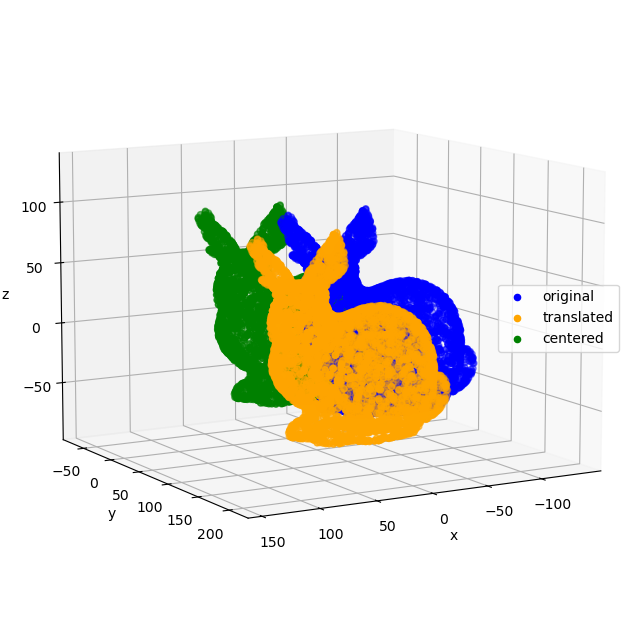

In [9]:
# Translated points
translation = np.array([50., 40., -10.])
translated_points = points + translation
# Centered points
centroid = points.mean(axis=0)
centered_points = points - centroid

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(translated_points[:, 0], translated_points[:, 1], translated_points[:, 2],
           c='orange', label="translated")
ax.scatter(centered_points[:, 0], centered_points[:, 1], centered_points[:, 2],
           c='green', label="centered")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

### Rotations

**A rotation moves every point of the pointcloud around a certain axis and by a certain angle** (called $\theta$ here).

A rotation is said to be *elemental* (or *basic*) when considering one of the axes of the main coordinate system (i.e., $x$, $y$, and $z$). Rotation matrices around each axis are then given below. A rotation around the $x$ axis leave the first coordinate of each point unchanged, and so on.

\begin{equation*}
R_{x}(\theta_x) = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & \cos\theta_x & -\sin\theta_x \\
0 & \sin\theta_x & \cos\theta_x
\end{pmatrix}
\quad
R_{y}(\theta_y) = 
\begin{pmatrix}
\cos\theta_y & 0 & \sin\theta_y \\
0 & 1 & 0 \\
-\sin\theta_y & 0 & \cos\theta_y
\end{pmatrix}
\quad
R_{z}(\theta_z) = 
\begin{pmatrix}
\cos\theta_z & -\sin\theta_z & 0 \\
\sin\theta_z & \cos\theta_z & 0 \\
0 & 0 & 1 
\end{pmatrix}
\end{equation*}

These rotations are counter-clockwise when the rotation axis is directed towards the observer (if the three-dimensional space is oriented according to the usual conventions, see the right-hand rule). Note that these rotations occur around the origin of the main coordinate system.

In practice, matrix multiplication is used to rotate each point of the pointcloud (do not forget that some attributes such as normals must also be rotated as well!). Due to the initial *row-wise* listing of points, some transpose operations are however necessary to keep dimensions consistent: 
\begin{equation*}
p' = (R(\theta).p^{T})^{T}
\end{equation*}
Again, thanks to broadcasting this operation may be vectorized in Numpy, resulting in more readable code and faster execution.

Some extra steps are necessary if a *local* coordinate system were to be considered. For example, for an "in-place" rotation, around the pointcloud center of mass (without any change in the axes direction), a simple solution consists in centering the pointcloud first, applying the rotation, and then moving the pointcloud around its original centroid.


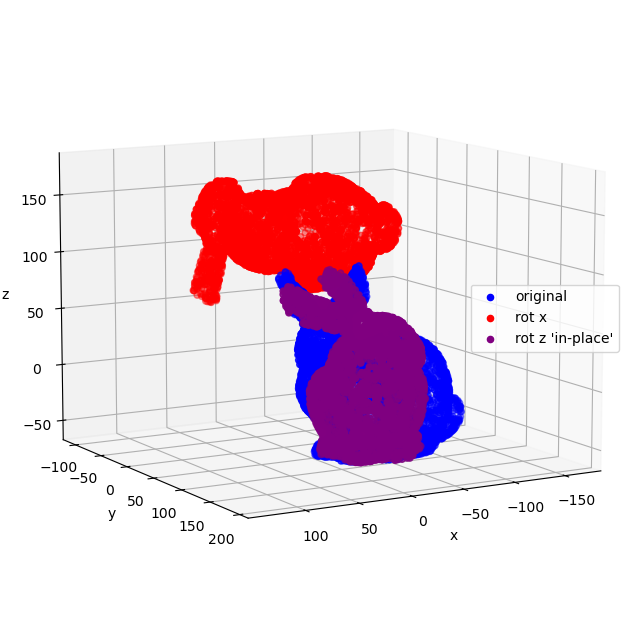

In [10]:
# Rotation around x
theta_x = np.pi/2 # or 90 degrees
R_x = np.array([
    [1., 0., 0.],
    [0., np.cos(theta_x), -np.sin(theta_x)],
    [0., np.sin(theta_x), np.cos(theta_x)]
])
points_rot_x = (R_x @ points.T).T
# Rotation around z "in-place"
theta_z = np.pi/3 # or 120 degrees
R_z = np.array([
    [np.cos(theta_z), -np.sin(theta_z), 0.],
    [np.sin(theta_z), np.cos(theta_z), 0.],
    [0., 0., 1.]
])
points_rot_z = (R_z @ centered_points.T).T + centroid

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_rot_x[:, 0], points_rot_x[:, 1], points_rot_x[:, 2],
           c='red', label="rot x")
ax.scatter(points_rot_z[:, 0], points_rot_z[:, 1], points_rot_z[:, 2],
           c='purple', label="rot z 'in-place'")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

A rotation matrix may also be computed using an arbitrary axis (i.e., different from one of the axes of the main coordinate system). Given a unit vector $u$ (on the axis) and angle $\theta$, the rotation matrix is written:

\begin{equation*}
R_{u}(\theta_u) = 
\begin{pmatrix}
u_{x}^{2}(1-\cos\theta_u)+\cos\theta_u & u_{x}u_{y}(1-\cos\theta_u)-u_{z}\sin\theta_u & u_{x}u_{z}(1-\cos\theta_u)+u_{y}\sin\theta_u \\
u_{x}u_{y}(1-\cos\theta_u)+u_{z}\sin\theta_u & u_{y}^{2}(1-\cos\theta_u)+\cos\theta_u & u_{y}u_{z}(1-\cos\theta_u)-u_{x}\sin\theta_u \\
u_{x}u_{z}(1-\cos\theta_u)-u_{y}\sin\theta_u & u_{y}u_{z}(1-\cos\theta_u)+u_{x}\sin\theta_u & u_{z}^{2}(1-\cos\theta_u)+\cos\theta_u
\end{pmatrix}
\end{equation*}


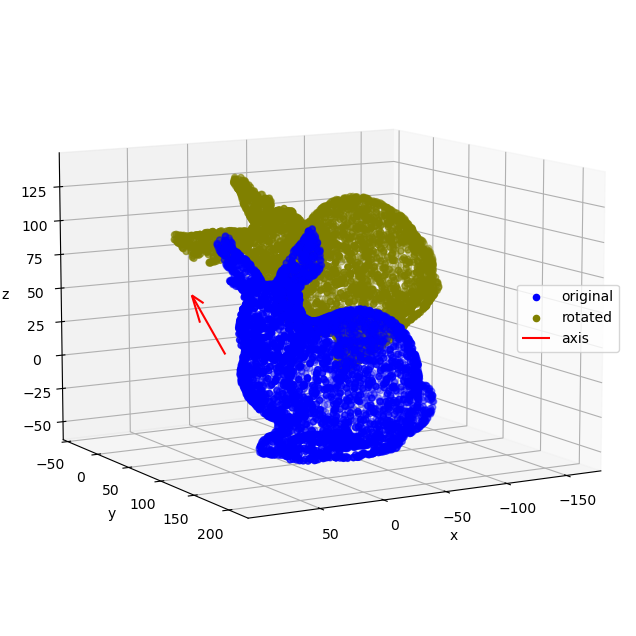

In [11]:
# Rotation around
u = np.array([np.sqrt(3)/3, np.sqrt(3)/3, np.sqrt(3)/3])
u_x, u_y, u_z = u
theta = np.pi/4 # or 45 degrees
c, s = np.cos(theta), np.sin(theta)
R_u = np.array([
    [(u_x**2)*(1-c)+c, u_x*u_y*(1-c)-u_z*s, u_x*u_z*(1-c)+u_y*s],
    [u_x*u_y*(1-c)+u_z*s, (u_y**2)*(1-c)+c, u_y*u_z*(1-c)-u_x*s],
    [u_x*u_z*(1-c)-u_y*s, u_y*u_z*(1-c)+u_x*s, (u_z**2)*(1-c)+c]
])
points_rot_u = (R_u @ points.T).T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_rot_u[:, 0], points_rot_u[:, 1], points_rot_u[:, 2],
           c='olive', label="rotated")
ax.quiver(0., 0., 0., 100.*u_x, 100.*u_y, 100.*u_z,
          color='red', label="axis") # axis of rotation
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

It is then possible to obtain any rotation matrix from the three elemental rotation matrices seen above.

Although commonly used, this approach should be treated with caution. Remember, for example, that matrix multiplication is not commutative ($R_{x}.R_{y} \neq R_{y}.R_{x}$), so order does matter. Consequently, there are many possible rotation sequences (x-y-z, y-z-x, z-x-y, etc.). What's more, each additional rotation may also refer to either the global coordinate system (extrinsic rotation) or to the last rotated coordinate system (intrinsic rotation).

Without going into too much detail, note **there is not a single "good" way of defining a rotation matrix in terms of elemental rotations**. That's why quaternions are often preferred when compacity, efficiency, and numerical stability are important.

Check if rotations R_t1 and R_t2 are the same: False


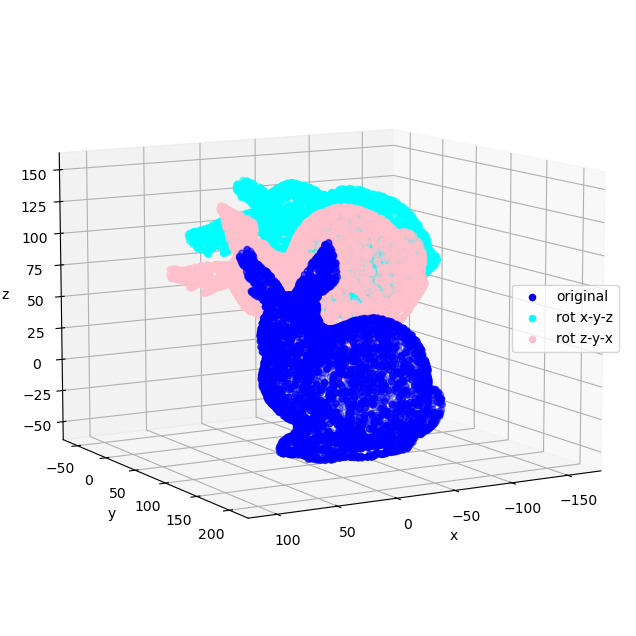

In [12]:
# Rotation around x
theta_x, theta_y, theta_z = np.pi/5, np.pi/6, np.pi/7
R_x = np.array([
    [1., 0., 0.],
    [0., np.cos(theta_x), -np.sin(theta_x)],
    [0., np.sin(theta_x), np.cos(theta_x)]
])
R_y = np.array([
    [np.cos(theta_y), 0., np.sin(theta_y)],
    [0., 1., 0.],
    [-np.sin(theta_y), 0., np.cos(theta_y)]
])
R_z = np.array([
    [np.cos(theta_z), -np.sin(theta_z), 0.],
    [np.sin(theta_z), np.cos(theta_z), 0.],
    [0., 0., 1.]
])
# First sequence of rotations (x-y-z)
R_xyz = R_x @ R_y @ R_z
points_rot_xyz = (R_xyz @ points.T).T
# Second sequence of rotations (z-y-x)
R_zyx = R_z @ R_y @ R_x
points_rot_zyx = (R_zyx @ points.T).T
# Comparison between the two sequences (not the same result)
print("Check if rotations R_t1 and R_t2 are the same:", np.allclose(points_rot_xyz, points_rot_zyx))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_rot_xyz[:, 0], points_rot_xyz[:, 1], points_rot_xyz[:, 2],
           c='cyan', label="rot x-y-z")
ax.scatter(points_rot_zyx[:, 0], points_rot_zyx[:, 1], points_rot_zyx[:, 2],
           c='pink', label="rot z-y-x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

We have seen how to compose $R_t$ given the angles $(\theta_x, \theta_y, \theta_z)$, but the inverse operation is also possible.

Given a rotation matrix and considering (for example) the extrinsic rotation z-y-x (the corresponding angles are often called *yaw*, *pitch*, and *roll* in aeronautics), the equations is written:
\begin{equation*}
\begin{aligned}
R_{t} & = 
\begin{pmatrix}
r_{00} & r_{01} & r_{02} \\
r_{10} & r_{11} & r_{12} \\
r_{20} & r_{21} & r_{22} \\
\end{pmatrix} \\
\\
 & =
\begin{pmatrix}
\cos\theta_y \cos\theta_z & \sin\theta_x \sin\theta_y \cos\theta_z - \cos\theta_x \sin\theta_z & \cos\theta_x \sin\theta_y \cos\theta_z + \sin\theta_x \sin\theta_z \\
\cos\theta_y \sin\theta_z & \sin\theta_x \sin\theta_y \sin\theta_z + \cos\theta_x \cos\theta_z & \cos\theta_x \sin\theta_y \sin\theta_z - \sin\theta_x \cos\theta_z \\
-\sin\theta_y & \sin\theta_x \cos\theta_y & \cos\theta_x \cos\theta_y \\
\end{pmatrix}
\end{aligned}
\end{equation*}

Using the bottom and left (simpler) terms for identification and remembering that $\tan{\theta}= \sin\theta / \cos\theta$ , it is possible to deduce that:
\begin{equation*}
\theta_{x} = arctan2(r_{21}, r_{22}) \quad
\theta_{y} = arctan2(-r_{20}, \sqrt{r^{2}_{21}+r^{2}_{22}}) \quad
\theta_{z} = arctan2(r_{10}, r_{00}) \quad
\end{equation*}

with $arctan2$ being the element-wise arc tangent of the ratio of the two numbers choosing the quadrant correctly.

Note that these angles satisfy the conditions $\theta_x \in [-\pi, \pi], \theta_y \in [-\frac{\pi}{2}, \frac{\pi}{2}], \theta_z \in [-\pi, \pi]$.



In [13]:
r_00, _, _, r_10, _, _, r_20, r_21, r_22 = R_zyx.flatten()
# Compute angles
theta_x_calc = np.arctan2(r_21, r_22)
theta_y_calc = np.arctan2(-r_20, np.sqrt(r_21**2 + r_22**2))
theta_z_calc = np.arctan2(r_10, r_00)
# Compare to initial angles
print("Check if theta_x_calc and theta_x are the same:", np.allclose(theta_x, theta_x_calc))
print("Check if theta_y_calc and theta_y are the same:", np.allclose(theta_y, theta_y_calc))
print("Check if theta_z_calc and theta_z are the same:", np.allclose(theta_z, theta_z_calc))

Check if theta_x_calc and theta_x are the same: True
Check if theta_y_calc and theta_y are the same: True
Check if theta_z_calc and theta_z are the same: True


### Reflections

**A reflection or "mirror" flips the pointcloud in a mirror plane** so that each point is the same distance from the mirror plane as its reflected point.

As for rotations, it is possible to consider reflections in the three planes built from the main coordinate system (i.e., $Oxy$, $Oyz$, and $Ozx$). A reflection in these planes leave the coordinates of each point unchanged except in the direction of their normals (e.g., the normal of the $Oxy$ plane is $y$) where the coordinate is "flipped".
\begin{equation*}
Rf_{x} = 
\begin{pmatrix}
-1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\quad
Rf_{y} = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & -1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\quad
Rf_{z} = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & -1
\end{pmatrix}
\end{equation*}

In practice, matrix multiplication is once again used to flip each point of the pointcloud (do not forget that some attributes such as normals must also be flipped as well!): 
\begin{equation*}
p' = (Rf.p^{T})^{T}
\end{equation*}

Again, centering the pointcloud first is necessary for an "in-place" mirror operation.

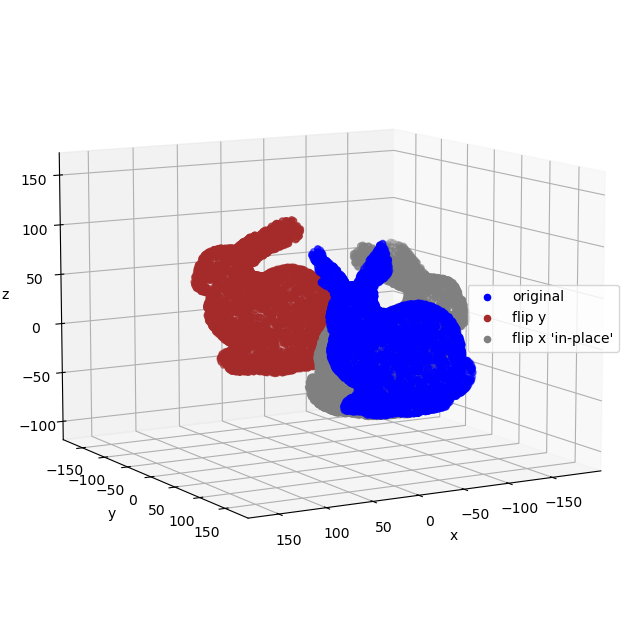

In [14]:
# Flip around y
Rf_y = np.array([
    [1., 0., 0.],
    [0., -1., 0.],
    [0., 0., 1.]
])
points_flip_y = (Rf_y @ points.T).T
# Flip around x "in-place"
Rf_x = np.array([
    [-1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.]
])
points_flip_x = (Rf_x @ centered_points.T).T + centroid

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_flip_y[:, 0], points_flip_y[:, 1], points_flip_y[:, 2],
           c='brown', label="flip y")
ax.scatter(points_flip_x[:, 0], points_flip_x[:, 1], points_flip_x[:, 2],
           c='gray', label="flip x 'in-place'")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

A reflection matrix may also be computed using an arbitrary plane.

A 3D plane $P$ is typically described by its cartesian equation $a.x + b.y + c.z + d = 0$, with $a$, $b$, and $c$ describing its orientation and $d$ its distance to origin. In this case, the plane normal is defined by $n = [a, b, c]$ (generally a unit vector) and any given point $p_i \in P$ verifies $p_i \cdot n = -d$. 

Remembering that a projection matrix on a plane going through the origin ($d = 0$) is given by:
\begin{equation*}
Pr_O = \frac{n^{T} \cdot n}{||n^2||} \iff Pr_O = n^{T} \cdot n \quad \text{for} \quad ||n|| = 1
\end{equation*}

It is possible to deduce that the reflection matrix is:
\begin{equation*}
Rf_O = I - 2 . n^{T} \cdot n =
\begin{pmatrix}
1-2a^2 & -2ab & -2ac \\
-2ab & 1-2b^2 & -2bc \\
-2ac & -2bc & 1-2c^2
\end{pmatrix}
\end{equation*}

(which may be seen as the original points' position subtracted by two times the distance to the plane).

Hence the coordinates of the mirrored points is given by:
\begin{equation*}
p'_O = (Rf_O.p^{T})^{T}
\end{equation*}

If the plane do not goes through the origin, a simple translation is added:
\begin{equation*}
p' = p'_O - 2 . d. n = (I - 2 . n^{T} \cdot n) \cdot p - 2 . d. n
\end{equation*}

Again, thanks to broadcasting this operation may be vectorized in Numpy, resulting in more readable code and faster execution.

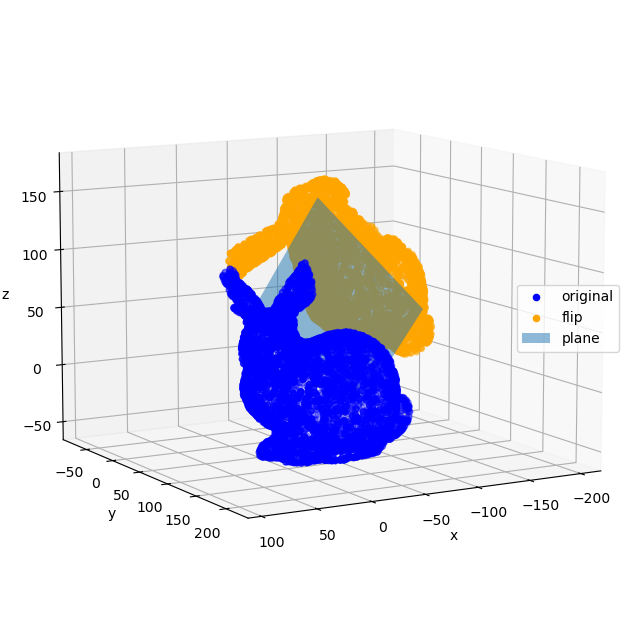

In [15]:
# Plane coordinates
n = np.array([-np.sqrt(3)/3, -np.sqrt(3)/3, np.sqrt(3)/3])
a, b, c = n
d = -10.
# Projection
Rf_O = np.eye(3) - 2 * n.reshape(-1, 1) @ n.reshape(1, -1) # n initial shape is (3,) and the dot product needs to be (3, 1)*(1, 3)
points_flip = (Rf_O @ points.T).T - 2 * d * n

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_flip[:, 0], points_flip[:, 1], points_flip[:, 2],
           c='orange', label="flip")
# plot plane
xx, yy = np.meshgrid(np.linspace(-100, 0, 2), np.linspace(50, 150, 2))
z = -(a*xx + b*yy + d)/c
ax.plot_surface(xx, yy, z, alpha=0.5, label="plane")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

Note that, as for rotations, it is perfectly possible to sequence the reflection operations seen above.

### Scaling

**Scaling or resizing increases or diminishes the dimensions of the pointcloud by a scale factor**.

When the scale factor is the same in all direction, scaling is said to be uniform or isotropic. In practice, the scale factor $s$ is simply used to multiply each point of the pointcloud:
\begin{equation*}
p' = s.p
\end{equation*}

When the scale factor is different in some directions, scaling is said to be non-uniform or anisotropic. Considering the three axes of the main coordinate system, we may deduce the following scaling matrix:
\begin{equation*}
Sc = 
\begin{pmatrix}
s_x & 0 & 0 \\
0 & s_y & 0 \\
0 & 0 & s_z
\end{pmatrix}
\end{equation*}
with $s_x$, $s_y$, and $s_z$ being the scale factors in the $x$, $y$, and $z$ direction respectively.

In practice, matrix multiplication is once again used to scale each point of the pointcloud (do not forget that some attributes such as normals must also be scaled as well!): 
\begin{equation*}
p' = (Sc.p^{T})^{T}
\end{equation*}

Again, centering the pointcloud first is necessary for an "in-place" scaling operation. You can indeed note that the scaled pointcloud "moves away" from the original one if the latter is not centered.


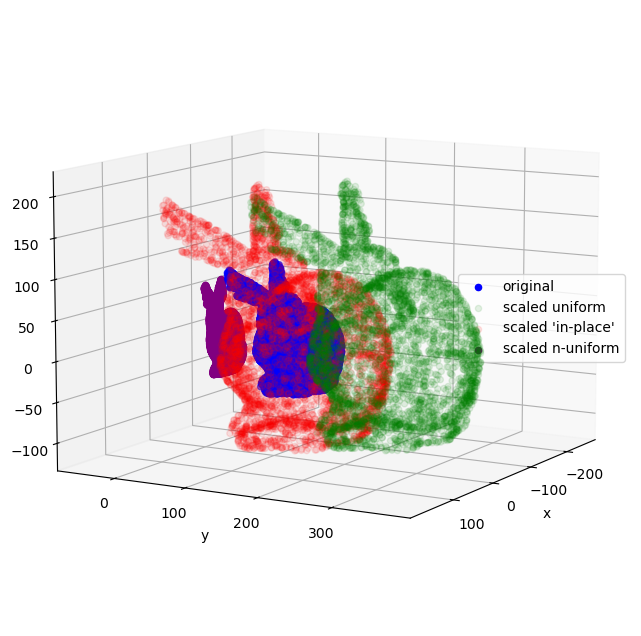

In [16]:
# Uniform scaling
s = 2.
points_u_scaled_1 = s * points
points_u_scaled_2 = s * centered_points + centroid
# Non uniform scaling
Sc = np.array([
    [.5, 0., 0.],
    [0., .2, 0.],
    [0., 0., .75]
])
points_nu_scaled = (Sc @ points.T).T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="original")
ax.scatter(points_u_scaled_1[:, 0], points_u_scaled_1[:, 1], points_u_scaled_1[:, 2],
           c='green', alpha=0.1, label="scaled uniform")
ax.scatter(points_u_scaled_2[:, 0], points_u_scaled_2[:, 1], points_u_scaled_2[:, 2],
           c='red', alpha=0.1, label="scaled 'in-place'")
ax.scatter(points_nu_scaled[:, 0], points_nu_scaled[:, 1], points_nu_scaled[:, 2],
           c='purple', label="scaled n-uniform")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 30)
plt.axis("equal")
plt.show()

### Going further

The latest subsections gave a glimpse of the most commonly found pointcloud transformations (i.e., affine transformations that include translations, rotations, reflections, scaling, and shearing) and how to implement them in a quite painless manner. You may however be starting to realize that this topic is not so simple at all. What's more, some aspects have been left out, such as shearing. A way longer notebook would have been necessary to go through them all in detail.

You may have noticed that **all the discussed transformations may be expressed as a combination of matrix multiplications and vector additions**. That's **because we used Cartesian coordinates**. In computer graphics and computer vision (both fields make extensive use of pointclouds or 3D representations that share some of their properties such as meshes), **these operations are often represented using a matrix multiplication only**, allowing simpler and more efficient processing, **thanks to Homogeneous coordinates**.

In Homogeneous coordinates, transformations are all expresses in the form of a $(4, 4)$ matrix. A first consequence is that the shape of pointcloud is slightly altered, with the addition of a fourth coordinate equal to 1, such as:
\begin{equation*}
p_i = [x_i, y_i, z_i, 1]
\end{equation*}
hence a basic pointcloud shape becomes $(n, 4)$ ($n$ being the total number of points).

With this notation, a translation matrix is written:
\begin{equation*}
\begin{pmatrix}
1 & 0 & 0 & t_x\\
0 & 1 & 0 & t_y\\
0 & 0 & 1 & t_z\\
0 & 0 & 0 & 1
\end{pmatrix}
\end{equation*}

Rotations around the main axes are written:
\begin{equation*}
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & \cos\theta_x & -\sin\theta_x & 0\\
0 & \sin\theta_x & \cos\theta_x & 0\\
0 & 0 & 0 & 1
\end{pmatrix}
\quad
\begin{pmatrix}
\cos\theta_y & 0 & \sin\theta_y & 0\\
0 & 1 & 0 & 0\\
-\sin\theta_y & 0 & \cos\theta_y & 0\\
0 & 0 & 0 & 1
\end{pmatrix}
\quad
\begin{pmatrix}
\cos\theta_z & -\sin\theta_z & 0 & 0 \\
\sin\theta_z & \cos\theta_z & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
\end{equation*}

and so on.

No need to be surprised if you encounter Homogeneous coordinates in more advanced pointcloud processing libraries or software then.

## Subsampling

**Subsampling**, also called decimation, **decreases the number of points of the pointcloud**. This is mostly motivated by a pointcloud being too large, causing visualization or processing performance issues.

There are mainly two types of subsampling approach: random and spatial based. The latter relies on specific spatial structures (e.g., voxel grids, octrees, or k-d trees) and are then left for a next notebook. Random subsampling consists in picking randomly a given number of points from the original pointcloud, discarding the others.

In practice, several methods may be used for random subsampling. A straightforward one takes advantage of Numpy random number generation and indexing capabilities. If the expected number of points is a whole divisor of the initial number of points, Numpy slicing capabilities may come handy.

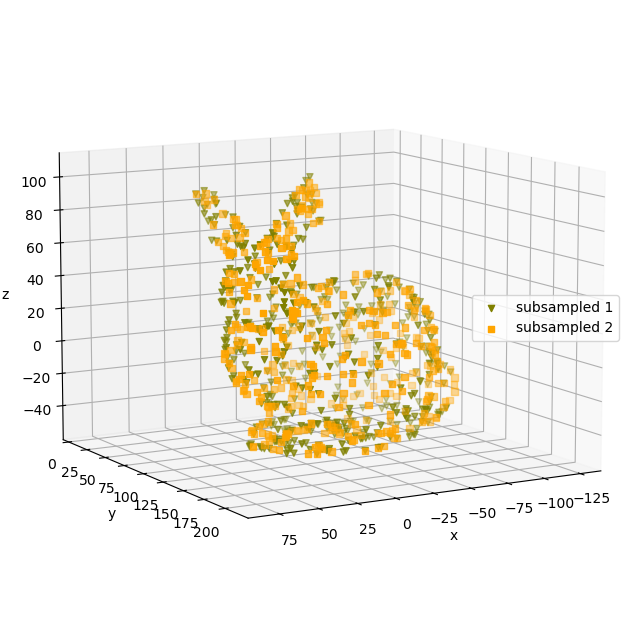

In [17]:
# Number of remaining points
size = 500
indices = np.random.choice(len(points), size=size, replace=False) # random indices of remaining points
points_sub_2_3rd = points[indices]

# Integer ratio of remaining points
points_sub_5th = points[::10] # slice of [start:stop:step]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_sub_2_3rd[:, 0], points_sub_2_3rd[:, 1], points_sub_2_3rd[:, 2],
           c='olive', marker="v", label="subsampled 1")
ax.scatter(points_sub_5th[:, 0], points_sub_5th[:, 1], points_sub_5th[:, 2],
           c='orange', marker="s", label="subsampled 2")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

Note that, as expected, the density of point in the subsampled pointclouds is very irregular. This is the major drawback of this random approach which, on the other hand, is computationally efficient and easy to implement.

## Wrapping up

You should now have a better grasp of what a pointcloud is, and how to perform basic operations on it. These fundamentals are needed to deal with the more advanced processing algorithms that are discussed in the next notebooks.

One key takeaway is that pointclouds represents a shape in a quite simple manner, as sets of 3D points in space, possibly with additional attributes such as normals, colors, etc. This means that the "order" in which the points are listed is in practice unimportant and it also underlines the discrete nature of this kind of representation.

Another more practical key takeaway it that pointcloud may be manipulated quite simply using Numpy and visualized with Matplotlib (should the number of points be in the thousand range for the latter). Vectorization is key to keep the code both readable and efficient (as a rule of thumb, try to avoid for loops as much as you can). Basic manipulations of pointclouds of up to a million of points in a "reasonable" time should be possible even with a standard laptop.

However, as mentioned before, pointclouds are unordered (e.g., as opposed to meshes, for which connections exist between vertices) which make some more advanced calculations more difficult. This is why spatial structures are often built to compensate for this lack of order. This is the subject of the next notebook.
